In [1]:
# Importing modules needed for the problem
from __future__ import division, print_function, unicode_literals
import os
import gc
import random

# Timer
from timeit import default_timer as timer

# Basic dataframe, array, and math stuff
import pandas as pd
import math
import numpy as np

# Scikit Learn
import sklearn as sk
from sklearn.preprocessing import Imputer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split as tts
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

# Tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib

# Keras
import keras
from keras.utils import to_categorical
from keras.models import Sequential, Input, Model
from keras import layers
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Input, Add, Activation, ZeroPadding2D, BatchNormalization
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import keras.backend as K
from keras.backend.tensorflow_backend import set_session, clear_session, get_session

import pydot
from IPython.display import SVG
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import imshow
from PIL import Image
import cv2
import glob
import imageio


Using TensorFlow backend.


## importing data

25000


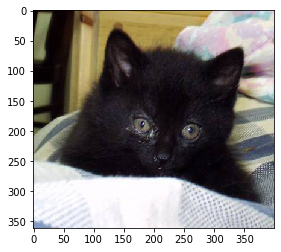

In [2]:
myf=glob.glob('train/*.jpg')
z=[]
all=np.zeros(25000) # Start by labeling all pictures as cats
all[12500:25000]=1 # label dogs
file_path = "C:\\Users\\User\\Desktop\\Northwestern\\422-Practical Machine Learning\\Weekly Assignments\\Week-7 Deep Learning-CNN\\Assignment\\"

count=0
for i in myf:
    tempname = str(file_path+str(myf[count]))
    tempdata = [all[count], tempname]
    z.append(tempdata)
    count+=1
    
dim1=len(myf)
print(len(myf))
f=imageio.imread(myf[2500])
plt.imshow(f)
plt.show()

testfiles=[]
count=0
testf=glob.glob('test/*.jpg')
for j in testf:
    tempname=str(file_path+str(testf[count]))
    testfiles.append(tempname)
    count+=1


### Training and Test Data Building

(342, 301, 3)


2573

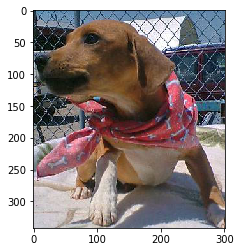

In [3]:
picnum=20000

z=pd.DataFrame(z,columns=['label','id'])

testfiles=pd.DataFrame(testfiles, columns=['id'])

imshow(plt.imread(z['id'][picnum]), 'hot')

print(plt.imread(z['id'][picnum]).shape)

z['label']=z['label'].astype(str)

random.seed(1234)
msk = np.random.rand(len(z))<0.8
z1=z[msk]
z2=z[~msk]
gc.collect()





## Model

In [4]:
mysize=128
mybatch=32
trainingsteps=np.ceil(20000/mysize)
valsteps=np.ceil(12500/mysize)

model=Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(mysize, mysize, 3)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [5]:
random.seed(1234)
acc=[]
loss=[]
tngacc=[]
tngloss=[]

aug=ImageDataGenerator(rescale=1./255,rotation_range=20,zoom_range=0.1,
                       width_shift_range=0.1,height_shift_range=0.1,shear_range=0.1,
                       horizontal_flip=True,fill_mode='nearest')

train_generator=aug.flow_from_dataframe(dataframe=z1,directory=None,x_col='id',y_col='label',
                                        class_mode='categorical',target_size=(mysize,mysize),
                                        shuffle=True,batch_size=mybatch,seed=40)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(z2,x_col='id',y_col='label',class_mode='categorical',
                                                target_size=(mysize,mysize), batch_size=mybatch,seed=41)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(testfiles,x_col='id',directory=None,color_mode='rgb',
                                                  target_size=(mysize,mysize),batch_size=1,class_mode=None,
                                                  shuffle=False,seed=42)

Found 20040 validated image filenames belonging to 2 classes.
Found 4960 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


In [6]:
model=model
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.adam(lr=0.0001,beta_1=0.5, beta_2=0.999),
              metrics=['binary_accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 58, 58, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 64)       

In [7]:
mysave=keras.callbacks.ModelCheckpoint('mymod.hdf5', save_best_only=True, monitor='val_loss', mode='min')

my_train = model.fit_generator(train_generator,steps_per_epoch=trainingsteps,epochs=300,callbacks=[mysave],
                               validation_data=val_generator,
                               validation_steps=valsteps)

model.save('my_model.h5')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/300
157/157 [==============================] - 352s 2s/step - loss: 0.6926 - binary_accuracy: 0.5227 - val_loss: 0.6947 - val_binary_accuracy: 0.4955
Epoch 2/300
157/157 [==============================] - 341s 2s/step - loss: 0.6880 - binary_accuracy: 0.5412 - val_loss: 0.6638 - val_binary_accuracy: 0.5998
Epoch 3/300
157/157 [==============================] - 341s 2s/step - loss: 0.6636 - binary_accuracy: 0.6017 - val_loss: 0.6407 - val_binary_accuracy: 0.6719
Epoch 4/300
157/157 [==============================] - 339s 2s/step - loss: 0.6183 - binary_accuracy: 0.6706 - val_loss: 0.5427 - val_binary_accuracy: 0.6923
Epoch 5/300
157/157 [==============================] - 330s 2s/step - loss: 0.5916 - binary_accuracy: 0.6827 - val_loss: 0.5834 - val_binary_accuracy: 0.6990
Epoch 6/300
157/157 [==============================] - 328s 2s/step - loss: 0.5873 - binary_accuracy: 0.6846 - val_

157/157 [==============================] - 330s 2s/step - loss: 0.3482 - binary_accuracy: 0.8432 - val_loss: 0.3389 - val_binary_accuracy: 0.8540
Epoch 50/300
157/157 [==============================] - 330s 2s/step - loss: 0.3386 - binary_accuracy: 0.8502 - val_loss: 0.3306 - val_binary_accuracy: 0.8578
Epoch 51/300
157/157 [==============================] - 330s 2s/step - loss: 0.3444 - binary_accuracy: 0.8487 - val_loss: 0.2295 - val_binary_accuracy: 0.8453
Epoch 52/300
157/157 [==============================] - 330s 2s/step - loss: 0.3510 - binary_accuracy: 0.8410 - val_loss: 0.3250 - val_binary_accuracy: 0.8520
Epoch 53/300
157/157 [==============================] - 330s 2s/step - loss: 0.3324 - binary_accuracy: 0.8481 - val_loss: 0.1860 - val_binary_accuracy: 0.8622
Epoch 54/300
157/157 [==============================] - 330s 2s/step - loss: 0.3429 - binary_accuracy: 0.8422 - val_loss: 0.4305 - val_binary_accuracy: 0.8632
Epoch 55/300
157/157 [==============================] - 330

157/157 [==============================] - 333s 2s/step - loss: 0.2409 - binary_accuracy: 0.9016 - val_loss: 0.3507 - val_binary_accuracy: 0.8996
Epoch 101/300
157/157 [==============================] - 335s 2s/step - loss: 0.2395 - binary_accuracy: 0.8981 - val_loss: 0.2055 - val_binary_accuracy: 0.9126
Epoch 102/300
157/157 [==============================] - 333s 2s/step - loss: 0.2360 - binary_accuracy: 0.9084 - val_loss: 0.1724 - val_binary_accuracy: 0.9002
Epoch 103/300
157/157 [==============================] - 334s 2s/step - loss: 0.2189 - binary_accuracy: 0.9076 - val_loss: 0.1677 - val_binary_accuracy: 0.9072
Epoch 104/300
157/157 [==============================] - 334s 2s/step - loss: 0.2232 - binary_accuracy: 0.9086 - val_loss: 0.3264 - val_binary_accuracy: 0.9123
Epoch 105/300
157/157 [==============================] - 335s 2s/step - loss: 0.2334 - binary_accuracy: 0.9027 - val_loss: 0.3147 - val_binary_accuracy: 0.9069
Epoch 106/300
157/157 [==============================]

157/157 [==============================] - 334s 2s/step - loss: 0.1834 - binary_accuracy: 0.9268 - val_loss: 0.0260 - val_binary_accuracy: 0.9385
Epoch 152/300
157/157 [==============================] - 334s 2s/step - loss: 0.1773 - binary_accuracy: 0.9256 - val_loss: 0.0246 - val_binary_accuracy: 0.9203
Epoch 153/300
157/157 [==============================] - 335s 2s/step - loss: 0.1763 - binary_accuracy: 0.9309 - val_loss: 0.2745 - val_binary_accuracy: 0.9238
Epoch 154/300
157/157 [==============================] - 335s 2s/step - loss: 0.1744 - binary_accuracy: 0.9275 - val_loss: 0.0872 - val_binary_accuracy: 0.9295
Epoch 155/300
157/157 [==============================] - 334s 2s/step - loss: 0.1698 - binary_accuracy: 0.9303 - val_loss: 0.1485 - val_binary_accuracy: 0.9212
Epoch 156/300
157/157 [==============================] - 333s 2s/step - loss: 0.1689 - binary_accuracy: 0.9302 - val_loss: 0.0722 - val_binary_accuracy: 0.9356
Epoch 157/300
157/157 [==============================]

157/157 [==============================] - 333s 2s/step - loss: 0.1440 - binary_accuracy: 0.9423 - val_loss: 0.1327 - val_binary_accuracy: 0.9327
Epoch 203/300
157/157 [==============================] - 332s 2s/step - loss: 0.1436 - binary_accuracy: 0.9418 - val_loss: 0.0965 - val_binary_accuracy: 0.9365
Epoch 204/300
157/157 [==============================] - 333s 2s/step - loss: 0.1469 - binary_accuracy: 0.9391 - val_loss: 0.0677 - val_binary_accuracy: 0.9267
Epoch 205/300
157/157 [==============================] - 331s 2s/step - loss: 0.1483 - binary_accuracy: 0.9410 - val_loss: 0.1539 - val_binary_accuracy: 0.9334
Epoch 206/300
157/157 [==============================] - 333s 2s/step - loss: 0.1518 - binary_accuracy: 0.9359 - val_loss: 0.0435 - val_binary_accuracy: 0.9343
Epoch 207/300
157/157 [==============================] - 333s 2s/step - loss: 0.1456 - binary_accuracy: 0.9427 - val_loss: 0.2528 - val_binary_accuracy: 0.9327
Epoch 208/300
157/157 [==============================]

157/157 [==============================] - 334s 2s/step - loss: 0.1214 - binary_accuracy: 0.9498 - val_loss: 0.1184 - val_binary_accuracy: 0.9365
Epoch 254/300
157/157 [==============================] - 333s 2s/step - loss: 0.1341 - binary_accuracy: 0.9466 - val_loss: 0.1102 - val_binary_accuracy: 0.9432
Epoch 255/300
157/157 [==============================] - 333s 2s/step - loss: 0.1244 - binary_accuracy: 0.9500 - val_loss: 0.1372 - val_binary_accuracy: 0.9391
Epoch 256/300
157/157 [==============================] - 334s 2s/step - loss: 0.1196 - binary_accuracy: 0.9508 - val_loss: 0.2034 - val_binary_accuracy: 0.9413
Epoch 257/300
157/157 [==============================] - 334s 2s/step - loss: 0.1220 - binary_accuracy: 0.9514 - val_loss: 0.1146 - val_binary_accuracy: 0.9423
Epoch 258/300
157/157 [==============================] - 334s 2s/step - loss: 0.1206 - binary_accuracy: 0.9538 - val_loss: 0.3181 - val_binary_accuracy: 0.9445
Epoch 259/300
157/157 [==============================]

# Results

In [8]:
test_generator.reset()
pred=model.predict_generator(test_generator,steps=12500, verbose=1)
predicted_class_indices=np.argmax(pred, axis=1)

labels=(train_generator.class_indices)
labels = dict((v,k) for k,v, in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames=test_generator.filenames
results=pd.DataFrame({'Filename':filenames, 'Predictions':predictions})
results.to_csv('results.csv', index=False)


12500/12500 [==============================] - 267s 21ms/step
